<a href="https://colab.research.google.com/github/AbdurRahmaneee/machine_learning_projects/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

There are two main benefits:
1. Can leverage neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own

In [ ]:
# Are we using a GPU?
!nvidia-smi

Fri Sep 16 13:27:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classed from Food101)

import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-09-16 13:27:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   177MB/s    in 0.9s    

2022-09-16 13:27:26 (177 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Create data loaders (preparing the data)

We'll use the `ImageDataGenerator` to load in our images in batches

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with TensorBoard callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback 

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


## Creating models using TensorFlow Hub
In the past we've used TensorFlow  to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the Tensorflow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE+ (3,)

(224, 224, 3)

In [ ]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of ourput neurons in output layer,
      should be equal to number of target classes, defaut 10.
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # freeze the already learned patterns
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,)) 
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model




In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220916-132744
Epoch 1/5
24/24 [==============================] - 33s 768ms/step - loss: 2.0090 - accuracy: 0.3387 - val_loss: 1.1900 - val_accuracy: 0.6248
Epoch 2/5
24/24 [==============================] - 16s 694ms/step - loss: 0.9188 - accuracy: 0.7093 - val_loss: 0.8454 - val_accuracy: 0.7228
Epoch 3/5
24/24 [==============================] - 17s 737ms/step - loss: 0.6225 - accuracy: 0.8160 - val_loss: 0.7324 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 16s 694ms/step - loss: 0.4790 - accuracy: 0.8787 - val_loss: 0.7003 - val_accuracy: 0.7716
Epoch 5/5
24/24 [==============================] - 16s 696ms/step - loss: 0.3894 - accuracy: 0.9093 - val_loss: 0.6550 - val_accuracy: 0.7900


Wow!

That is incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand.. (substantially) and in a quicker trainig time AND with only 10% of the training examples

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it..
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: Tensorflow History object.
  
  Returns:
    Plot of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

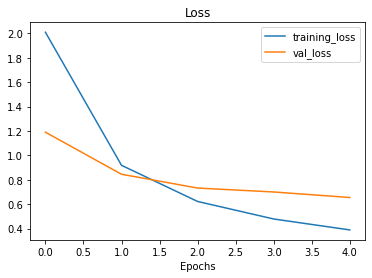

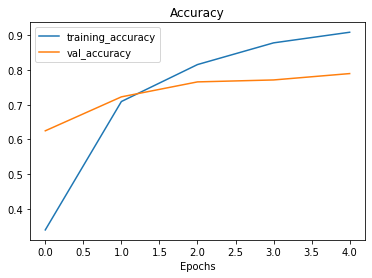

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics="accuracy")

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220916-132939
Epoch 1/5
24/24 [==============================] - 26s 736ms/step - loss: 1.8754 - accuracy: 0.4293 - val_loss: 1.3010 - val_accuracy: 0.7348
Epoch 2/5
24/24 [==============================] - 16s 694ms/step - loss: 1.0676 - accuracy: 0.7840 - val_loss: 0.8634 - val_accuracy: 0.8228
Epoch 3/5
24/24 [==============================] - 16s 670ms/step - loss: 0.7618 - accuracy: 0.8333 - val_loss: 0.6960 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 16s 671ms/step - loss: 0.6087 - accuracy: 0.8653 - val_loss: 0.6067 - val_accuracy: 0.8592
Epoch 5/5
24/24 [==============================] - 16s 665ms/step - loss: 0.5143 - accuracy: 0.8907 - val_loss: 0.5560 - val_accuracy: 0.8616


In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

In [ ]:
resnet_model.summary()

In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

In [ ]:
len(resnet_model.layers[0].weights)

270

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own.)
* **"Feature extraction"** transfer learning - use prelearned patternsof an existing (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Find-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)



## Comparing our models' results using TensorBoard

> 🔑 **Note:** When you upload things to Tensorboard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


Our TensorBoard experiments are uploaded publicly here: https://tensorboard.dev/experiment/oapsG27eRUqQzoEFPSVo8Q/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.7/dist-package

In [24]:
# Delete an experiment
!tensorboard dev delete --experiment_id oapsG27eRUqQzoEFPSVo8Q


***** TensorBoard Uploader *****

This will delete the 1 experiment(s) on
https://tensorboard.dev with the following experiment ID(s):

['oapsG27eRUqQzoEFPSVo8Q']

You have chosen to delete an experiment. All experiments uploaded
to TensorBoard.dev are publicly visible. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program

In [25]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 
***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.